## 1. Introduction

The aim of this investigation is the construction of classification models, capable of predicting the outcome of matches in the English Premier League (EPL).

To achieve this, historical data from the EPL has been utilized, so as to perform exploratory data analysis, extract meaningful information, determine suitable features and train accurate classification models. The maximum accuracy obtained through this investigation is <b>65.0%</b>.

In [4]:
import os
import urllib
import warnings

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

In [5]:
# warnings.filterwarnings('once')
warnings.filterwarnings('ignore')

cwd = os.getcwd()

## 2. Data Import

In [6]:
path = os.path.join(cwd, 'Data_Files', 'epl-training.csv')

columns = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR',
           'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']

df_epl = pd.read_csv(path)
df_epl = df_epl[columns]

df_epl.head()

# Retrieve Latest Data (Season 2021-22)
url = 'https://www.football-data.co.uk/mmz4281/2122/E0.csv'
path = os.path.join(cwd, 'Data_Files', 'E0.csv')

urllib.request.urlretrieve(url, path)

df_E0 = pd.read_csv(path)
df_E0 = df_E0[columns]

df_epl = df_epl.append(df_E0, ignore_index = True)

df_epl.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
5315,22/05/2022,Crystal Palace,Man United,1,0,H,1,0,H,M Atkinson,...,3,4,12,22,3,6,2,4,0,0
5316,22/05/2022,Leicester,Southampton,4,1,H,0,0,D,J Moss,...,6,2,10,5,3,3,0,1,0,0
5317,22/05/2022,Liverpool,Wolves,3,1,H,1,1,D,A Taylor,...,8,5,6,3,5,3,1,0,0,0
5318,22/05/2022,Man City,Aston Villa,3,2,H,0,1,A,M Oliver,...,5,2,5,11,13,1,0,1,0,0
5319,22/05/2022,Norwich,Tottenham,0,5,A,0,2,A,C Kavanagh,...,0,13,13,7,3,2,3,1,0,0


## 3. Data Transformation & Exploration

In [7]:
# Categorical Variables: Date, HomeTeam, AwayTeam, FTR, HTR, Referee
# Numerical Variables: FTHG, FTAG, HTHG, HTAG, HS, AS, HST, AST, HF, AF, HC, AC, HY, AY, HR, AR

In [8]:
# Existence of N/A Values
df_epl.isnull().values.sum()

0

In [9]:
# Number of Different Teams
df_epl['HomeTeam'].nunique()

39

In [10]:
# df_epl.info()
# df_epl.describe()

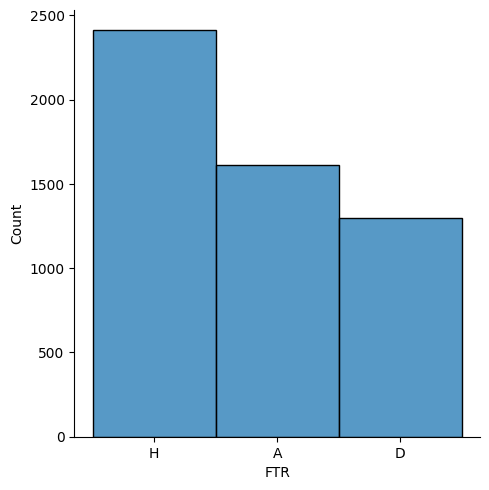

In [11]:
# Distribution of FTR - Balance of Classes
sns.displot(df_epl['FTR']);

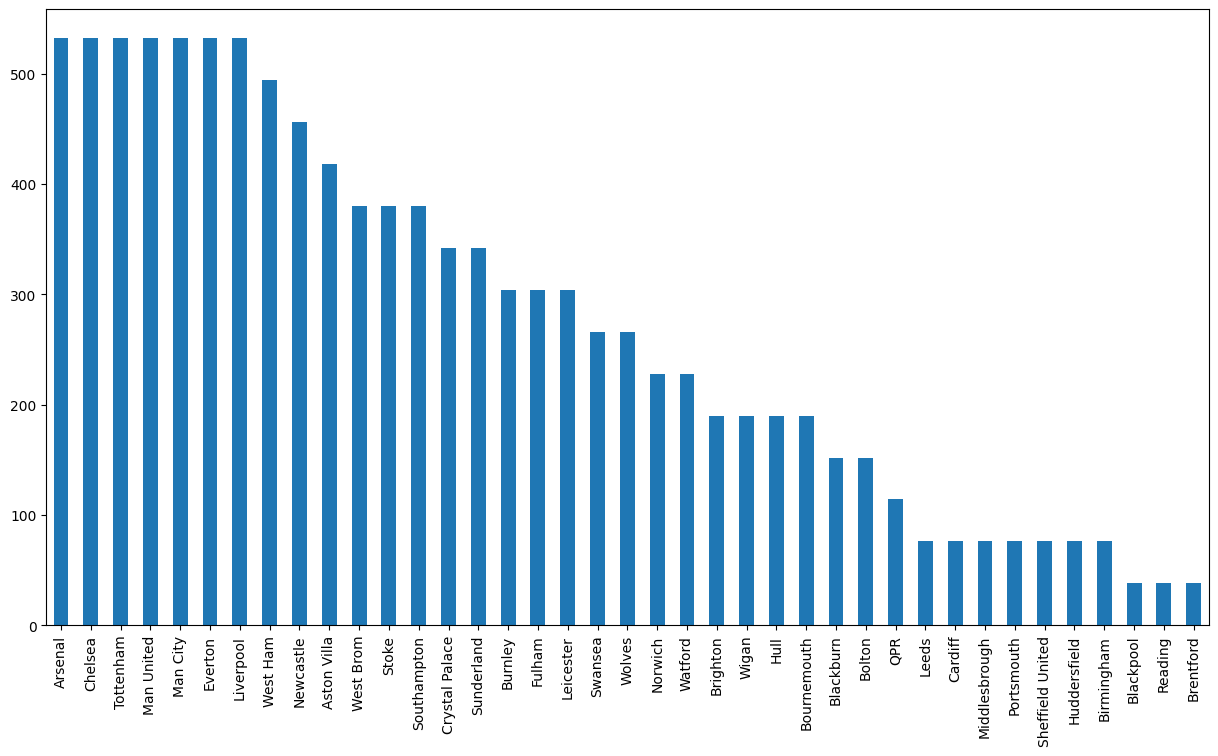

In [12]:
# Matches Played by Teams
matches = df_epl['HomeTeam'].value_counts() + df_epl['AwayTeam'].value_counts()
matches = matches.sort_values(ascending = False)

matches.plot(kind = 'bar', figsize = (15, 8));

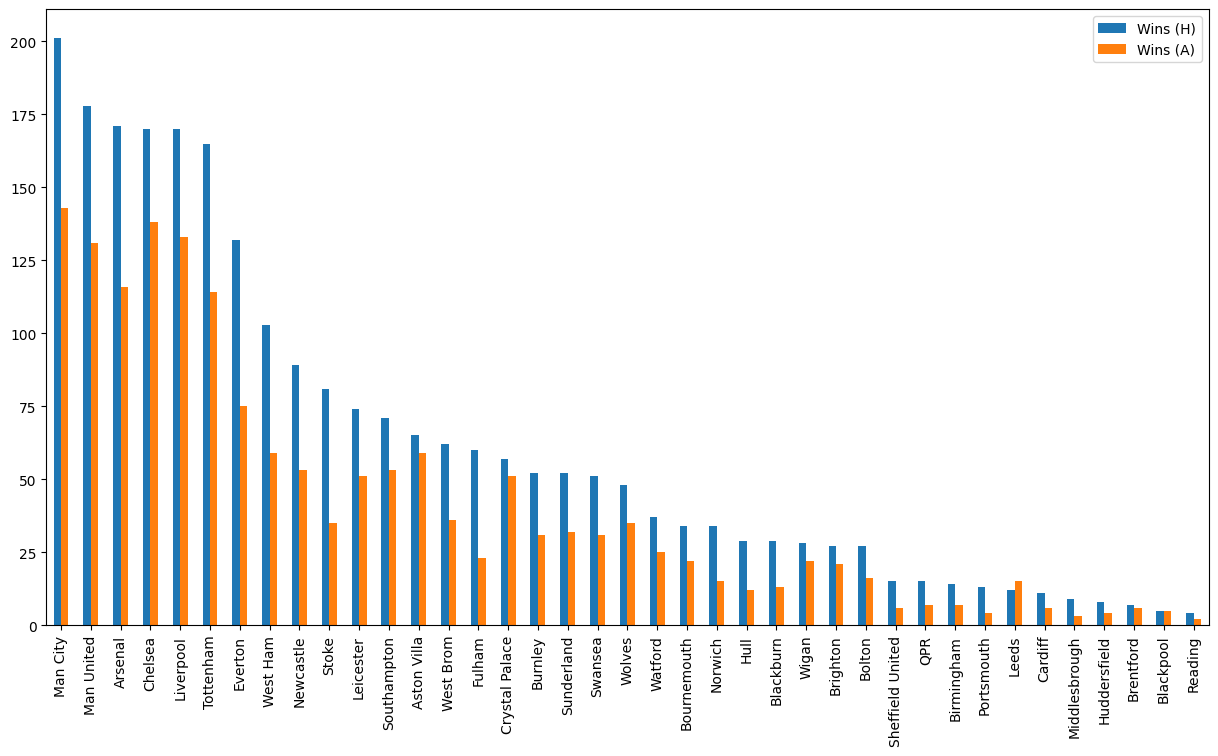

In [13]:
# Outcomes of Matches by Teams
outcomes = pd.DataFrame()

wins_H = df_epl.loc[df_epl['FTR'] == 'H', 'HomeTeam'].value_counts()
wins_A = df_epl.loc[df_epl['FTR'] == 'A', 'AwayTeam'].value_counts()

outcomes['Wins (H)'] = wins_H
outcomes['Wins (A)'] = wins_A

outcomes.plot(kind = 'bar', figsize = (15, 8));

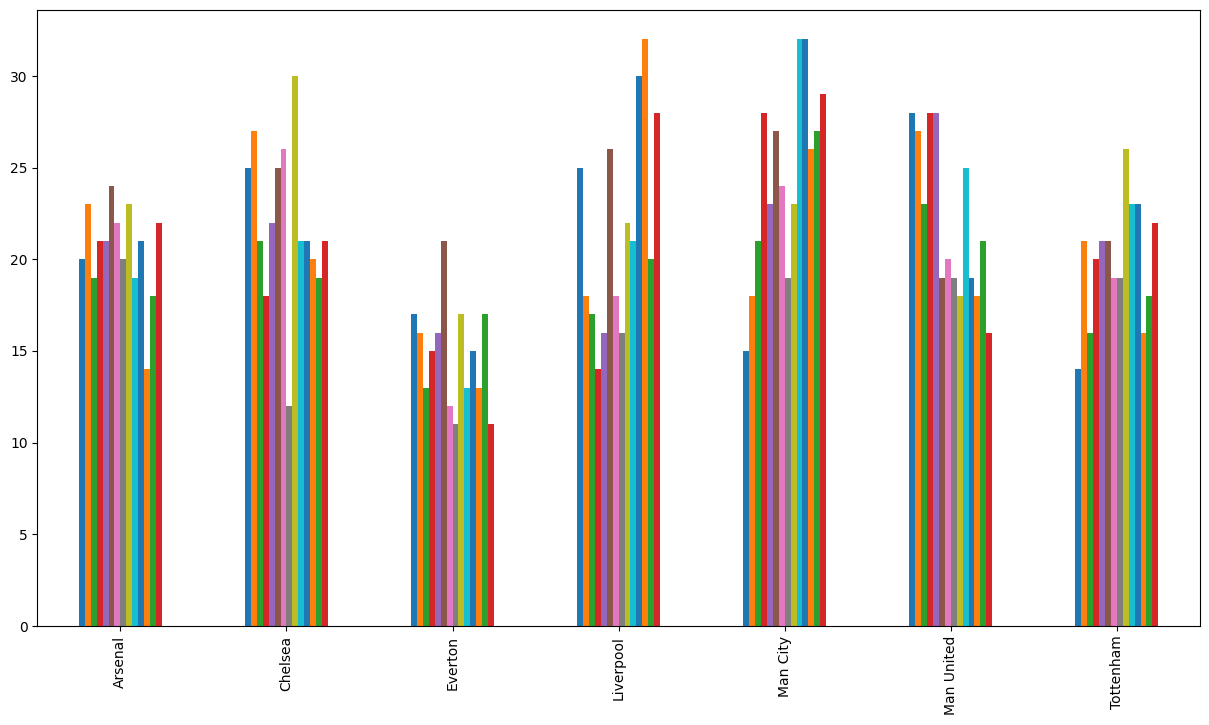

In [14]:
# Wins of Teams by Season
wins = pd.DataFrame()

# Games per Season
n = 380

# Number of Seasons
s = int(np.ceil(len(df_epl) / n))

seasons = [df_epl.iloc[i * n : (i + 1) * n] for i in range(s)]

for df_s in seasons:
    wins_H = df_s.loc[df_s['FTR'] == 'H', 'HomeTeam'].value_counts()
    wins_A = df_s.loc[df_s['FTR'] == 'A', 'AwayTeam'].value_counts()
    
    wins[len(wins.columns)] = wins_H + wins_A

# Remove Teams with NaN Values
wins.dropna(inplace = True)

wins.plot(kind = 'bar', figsize = (15, 8), legend = False);

In [15]:
# These are the teams that have competed in all EPLs in the dataset (14 Seasons).

# It is evident that past performance is not indicative of current performance, as there is
# substantial variation in the number of wins across different seasons, even for the best teams.

# Additionally, only 10 teams from the first season (2008-09) currently compete in EPL (2021-22).

# Thus, the first seasons in the dataset will be removed, as they are not representative of current performance
# and could introduce bias in the predictions. The models will be trained on data from season 2016-17 onwards.

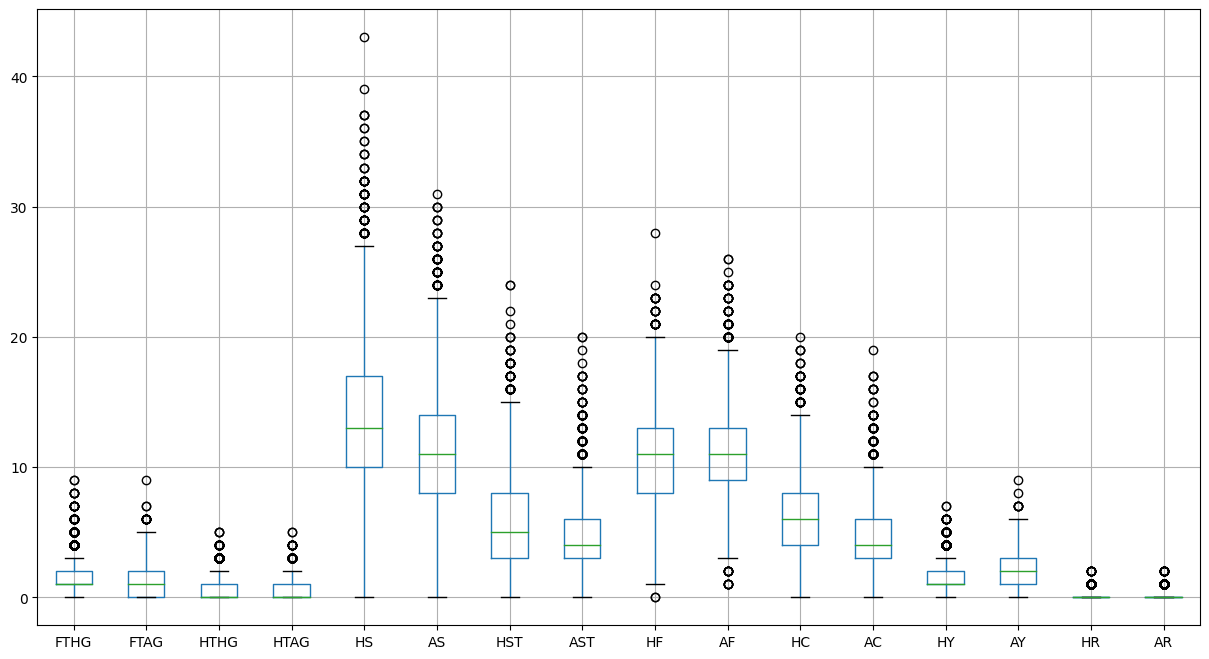

In [16]:
# Outliers in Numerical Features
df_epl.boxplot(figsize = (15, 8));

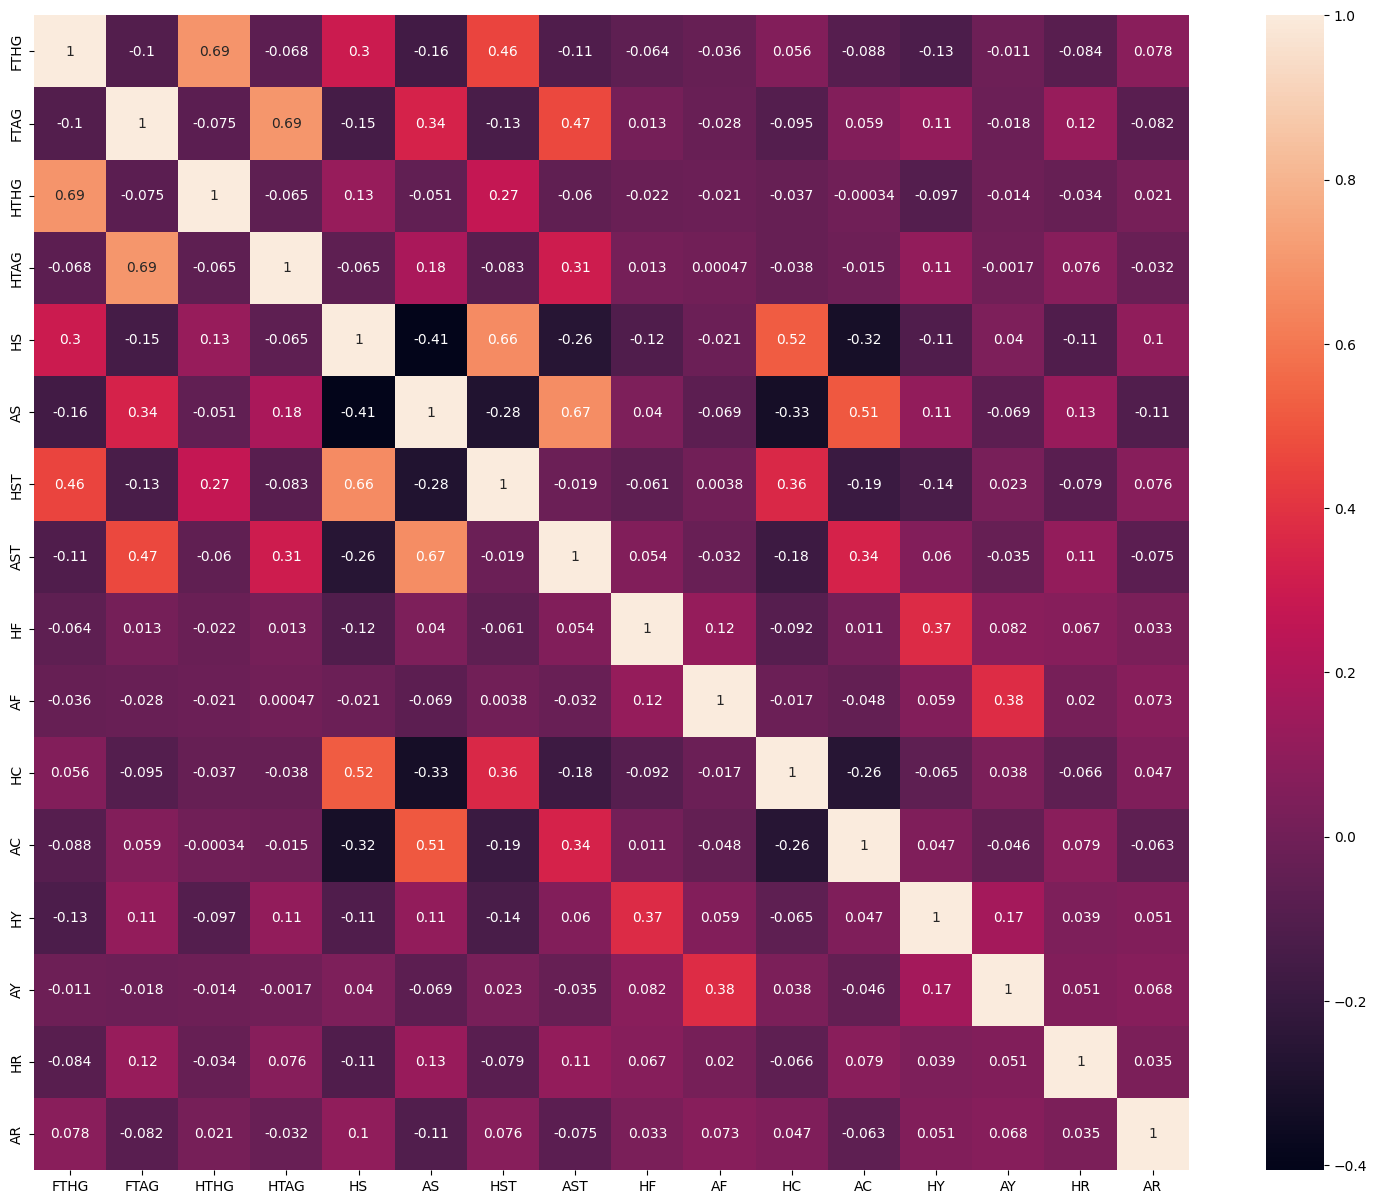

In [17]:
# Correlation of Numerical Features
fig, ax = plt.subplots(figsize = (20, 15))
sns.heatmap(df_epl.corr(), annot = True, square = True);

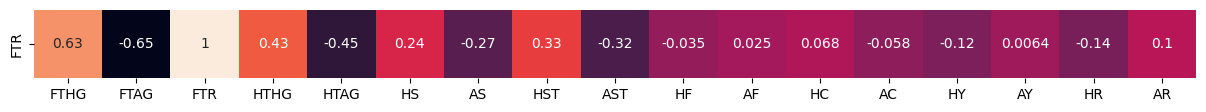

In [18]:
# Correlation (FTR)
df_cr = df_epl.copy()
df_cr['FTR'].replace({'H': 1, 'D': 0, 'A': -1}, inplace = True)

fig, ax = plt.subplots(figsize = (15, 2))
sns.heatmap(df_cr.corr()[['FTR']].T, annot = True, square = True, cbar = False);

In [19]:
# Strong Positive Correlation with FTR: FTHG, HTHG, HS, HST
# Strong Negative Correlation with FTR: FTAG, HTAG, AS, AST

# Red Cards (HR + AR): Intuitively strong correlation with FTR.
# However, there are few occurrences and could introduce bias.

# Fouls (HF + AF): Weak Correlation with FTR.
# Corners (HC + AC): Weak Correlation with FTR.
# Yellow Cards (HY + AY): Weak Correlation with FTR.

# Shots (HS + AS): Strong correlation with Shots on Target (HST + AST). Unnecessary.

# Half-Time Goals (HTHG + HTAG): Strong correlation with Full-Time Goals (FTHG + FTAG). Unnecessary.

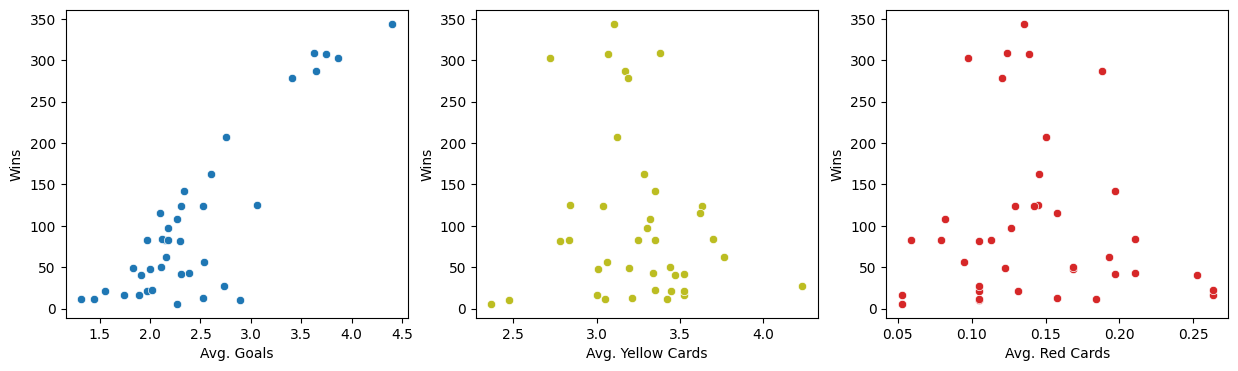

In [20]:
# Correlation of Cards and Wins
scatter = pd.DataFrame()

wins_H = df_epl.loc[df_epl['FTR'] == 'H', 'HomeTeam'].value_counts()
wins_A = df_epl.loc[df_epl['FTR'] == 'A', 'AwayTeam'].value_counts()

scatter['Wins'] = wins_H + wins_A

HG = df_epl.groupby('HomeTeam')['FTHG'].mean()
AG = df_epl.groupby('AwayTeam')['FTAG'].mean()

scatter['Avg. Goals'] = HG + AG

HY = df_epl.groupby('HomeTeam')['HY'].mean()
AY = df_epl.groupby('AwayTeam')['AY'].mean()

scatter['Avg. Yellow Cards'] = HY + AY

HR = df_epl.groupby('HomeTeam')['HR'].mean()
AR = df_epl.groupby('AwayTeam')['AR'].mean()

scatter['Avg. Red Cards'] = HR + AR

fig, (ax_G, ax_Y, ax_R) = plt.subplots(1, 3, figsize = (15, 4))

sns.scatterplot(x = 'Avg. Goals', y = 'Wins', data = scatter, color = 'tab:blue', ax = ax_G);
sns.scatterplot(x = 'Avg. Yellow Cards', y = 'Wins', data = scatter, color = 'tab:olive', ax = ax_Y);
sns.scatterplot(x = 'Avg. Red Cards', y = 'Wins', data = scatter, color = 'tab:red', ax = ax_R);

In [21]:
# Remove Unnecessary Features
df_epl = df_epl.drop(['HTHG', 'HTAG', 'HS', 'AS', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR'], axis = 1)

In [22]:
# Remove Unnecessary Seasons
n = 8

index = seasons[n].index[0]
df_epl = df_epl.iloc[index:].copy()

df_epl.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTR,Referee,HST,AST,HC,AC
3040,13/08/16,Burnley,Swansea,0,1,A,D,J Moss,3,9,7,4
3041,13/08/16,Crystal Palace,West Brom,0,1,A,D,C Pawson,4,3,3,6
3042,13/08/16,Everton,Tottenham,1,1,D,H,M Atkinson,6,4,5,6
3043,13/08/16,Hull,Leicester,2,1,H,H,M Dean,5,5,5,3
3044,13/08/16,Man City,Sunderland,2,1,H,H,R Madley,4,3,9,6


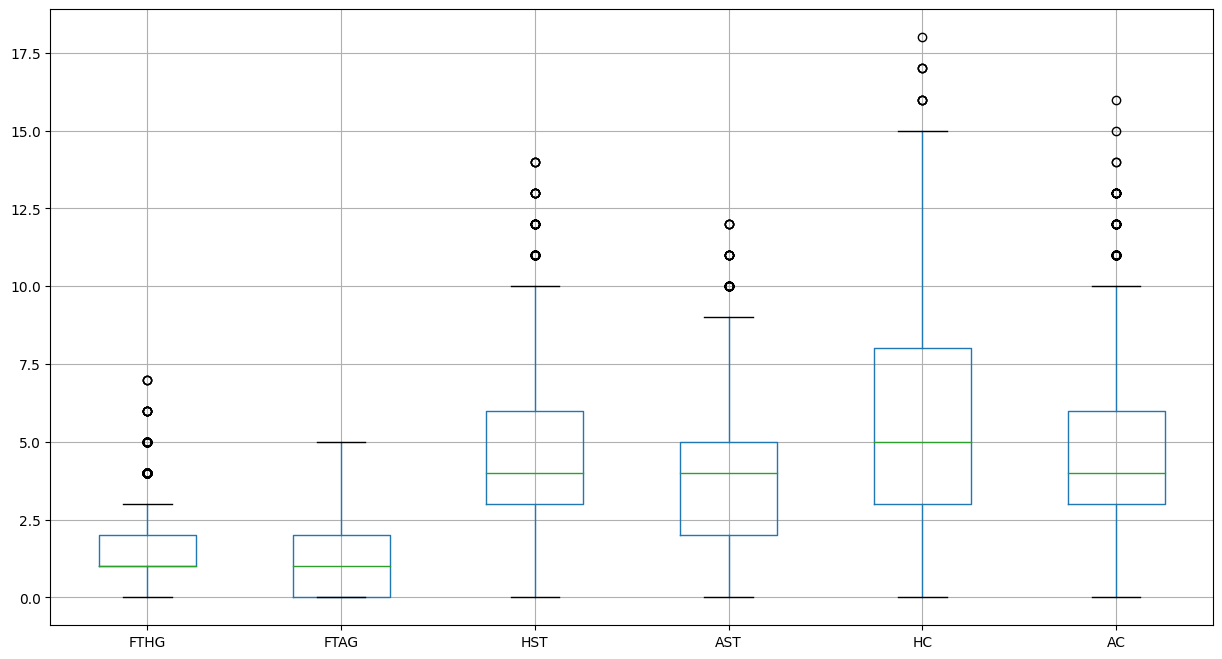

In [23]:
# Remove Outliers
Q1 = df_epl.quantile(0.15)
Q3 = df_epl.quantile(0.85)

IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# display(lower)
# display(upper)

df_epl, lower = df_epl.align(lower, join = 'left', axis = 1)
df_epl, upper = df_epl.align(upper, join = 'left', axis = 1)

df_epl = df_epl[~((df_epl < lower) | (df_epl > upper)).any(axis = 1)]

df_epl.boxplot(figsize = (15, 8));

## 4. Methodology Overview

In [24]:
# Team Strength
def get_TS(team):
    # Average Goals Scored by Team
    HG = df_epl.loc[df_epl['HomeTeam'] == team, 'FTHG'].mean()
    AG = df_epl.loc[df_epl['AwayTeam'] == team, 'FTAG'].mean()
    
    # Average Goals Conceded by Team
    HGC = df_epl.loc[df_epl['HomeTeam'] == team, 'FTAG'].mean()
    AGC = df_epl.loc[df_epl['AwayTeam'] == team, 'FTHG'].mean()
    
    # Goals Scored vs. Conceded
    TS = (HG + AG) / (HGC + AGC)
    
    return TS

# Team Win Ratio
def get_TWR(team):
    # Team Wins (H + A)
    WH = df_epl.loc[df_epl['HomeTeam'] == team, 'FTR'].value_counts()
    WH = WH.reindex(df_epl['FTR'].unique(), fill_value = 0)['H']
    
    WA = df_epl.loc[df_epl['AwayTeam'] == team, 'FTR'].value_counts()
    WA = WA.reindex(df_epl['FTR'].unique(), fill_value = 0)['A']
    
    # Team Matches (H + A)
    MH = df_epl.loc[df_epl['HomeTeam'] == team].shape[0]
    MA = df_epl.loc[df_epl['AwayTeam'] == team].shape[0]
    
    TWR = (WH + WA) / (MH + MA)

    return TWR

# Team Form (Last 4 Games)
def get_TF(team):
    # Team Wins in Last 2 Games (H)
    WH = df_epl.loc[df_epl['HomeTeam'] == team, 'FTR'].tail(2).value_counts()
    WH = WH.reindex(df_epl['FTR'].unique(), fill_value = 0)['H']
    
    # Team Wins in Last 2 Games (A)
    WA = df_epl.loc[df_epl['AwayTeam'] == team, 'FTR'].tail(2).value_counts()
    WA = WA.reindex(df_epl['FTR'].unique(), fill_value = 0)['A']
    
    TF = (WH + WA)
    
    return TF

# Team Conversion Rate
def get_TCR(team):
    # Average Goals Scored by Team
    HG = df_epl.loc[df_epl['HomeTeam'] == team, 'FTHG'].mean()
    AG = df_epl.loc[df_epl['AwayTeam'] == team, 'FTAG'].mean()
    
    # Average Shots on Target by Team
    HST = df_epl.loc[df_epl['HomeTeam'] == team, 'HST'].mean()
    AST = df_epl.loc[df_epl['AwayTeam'] == team, 'AST'].mean()
    
    # Average Corners Won by Team
    HC = df_epl.loc[df_epl['HomeTeam'] == team, 'HC'].mean()
    AC = df_epl.loc[df_epl['AwayTeam'] == team, 'AC'].mean()
    
    TCR = (HG + AG) / (HST + AST + HC + AC)
    
    return TCR

# Head to Head
def get_H2H(i, j):
    HA = df_epl.loc[(df_epl['HomeTeam'] == i) & (df_epl['AwayTeam'] == j), 'FTR'].value_counts()
    HA = HA.reindex(df_epl['FTR'].unique(), fill_value = 0)
    
    AH = df_epl.loc[(df_epl['HomeTeam'] == j) & (df_epl['AwayTeam'] == i), 'FTR'].value_counts()
    AH = AH.reindex(df_epl['FTR'].unique(), fill_value = 0)
    
    WH = HA['H'] + AH['A']
    WA = HA['A'] + AH['H']
    DR = HA['D'] + AH['D']
    
    TM = HA.sum() + AH.sum()
    if (TM == 0): return [0, 0, 0]
    
    H2H = [(WH / TM), (WA / TM), (DR / TM)]
    
    return H2H

In [25]:
# Construct DataFrame for Teams
columns = ['TEAM', 'TS', 'TWR', 'TF', 'TCR']

df_teams = pd.DataFrame(columns = columns)

df_teams['TEAM'] = df_epl['HomeTeam'].unique()

df_teams['TS'] = [get_TS(i) for i in df_teams['TEAM']]
df_teams['TF'] = [get_TF(i) for i in df_teams['TEAM']]
df_teams['TWR'] = [get_TWR(i) for i in df_teams['TEAM']]
df_teams['TCR'] = [get_TCR(i) for i in df_teams['TEAM']]

df_teams.head()

,TEAM,TS,TWR,TF,TCR
0,Burnley,0.718241,0.299559,0,0.132819
1,Crystal Palace,0.822664,0.312775,2,0.137738
2,Everton,0.947846,0.380531,1,0.144016
3,Hull,0.502981,0.243243,1,0.121929
4,Man City,2.962762,0.734234,3,0.172962


In [26]:
# Construct DataFrame for H2H
teams = df_epl['HomeTeam'].unique()

data = []

for i in teams:
    column = []
    
    for j in teams:
        column.append(get_H2H(i,j))
    
    data.append(column)

df_h2h = pd.DataFrame(data, columns = teams, index = teams)

In [27]:
# Construct DataFrame for Input
def create_DF(df_epl, df_teams):
    columns = ['HOME', 'AWAY', 'FTR', 'HTS', 'ATS', 'HTWR', 'ATWR',
               'HTF', 'ATF', 'HTCR', 'ATCR', 'H2H_H', 'H2H_A', 'H2H_D']

    df_input = pd.DataFrame(columns = columns)

    df_input['HOME'] = df_epl['HomeTeam']
    df_input['AWAY'] = df_epl['AwayTeam']

    df_input['FTR'] = df_epl['FTR']

    for index, row in df_teams.iterrows():
        df_input.loc[(df_input['HOME'] == row['TEAM']), 'HTS'] = row['TS']
        df_input.loc[(df_input['AWAY'] == row['TEAM']), 'ATS'] = row['TS']

        df_input.loc[(df_input['HOME'] == row['TEAM']), 'HTWR'] = row['TWR']
        df_input.loc[(df_input['AWAY'] == row['TEAM']), 'ATWR'] = row['TWR']

        df_input.loc[(df_input['HOME'] == row['TEAM']), 'HTF'] = row['TF']
        df_input.loc[(df_input['AWAY'] == row['TEAM']), 'ATF'] = row['TF']

        df_input.loc[(df_input['HOME'] == row['TEAM']), 'HTCR'] = row['TCR']
        df_input.loc[(df_input['AWAY'] == row['TEAM']), 'ATCR'] = row['TCR']

    df_input['H2H_H'] = [df_h2h.loc[i][j][0] for (i,j) in zip(df_input['HOME'], df_input['AWAY'])]
    df_input['H2H_A'] = [df_h2h.loc[i][j][1] for (i,j) in zip(df_input['HOME'], df_input['AWAY'])]
    df_input['H2H_D'] = [df_h2h.loc[i][j][2] for (i,j) in zip(df_input['HOME'], df_input['AWAY'])]
    
    df_input = df_input.apply(pd.to_numeric, errors = 'ignore')
    df_input.round(decimals = 4)
    
    return df_input

In [28]:
df_input = create_DF(df_epl, df_teams)

df_input.head()

,HOME,AWAY,FTR,HTS,ATS,HTWR,ATWR,HTF,ATF,HTCR,ATCR,H2H_H,H2H_A,H2H_D
3040,Burnley,Swansea,A,0.718241,0.601322,0.299559,0.266667,0,0,0.132819,0.122520,0.250000,0.750000,0.000000
3041,Crystal Palace,West Brom,A,0.822664,0.595628,0.312775,0.201754,2,0,0.137738,0.131643,0.666667,0.166667,0.166667
3042,Everton,Tottenham,D,0.947846,1.701214,0.380531,0.549550,1,2,0.144016,0.163468,0.090909,0.454545,0.454545
3043,Hull,Leicester,H,0.502981,1.085714,0.243243,0.398230,1,3,0.121929,0.153985,0.500000,0.500000,0.000000
3044,Man City,Sunderland,H,2.962762,0.403877,0.734234,0.162162,3,0,0.172962,0.098483,1.000000,0.000000,0.000000


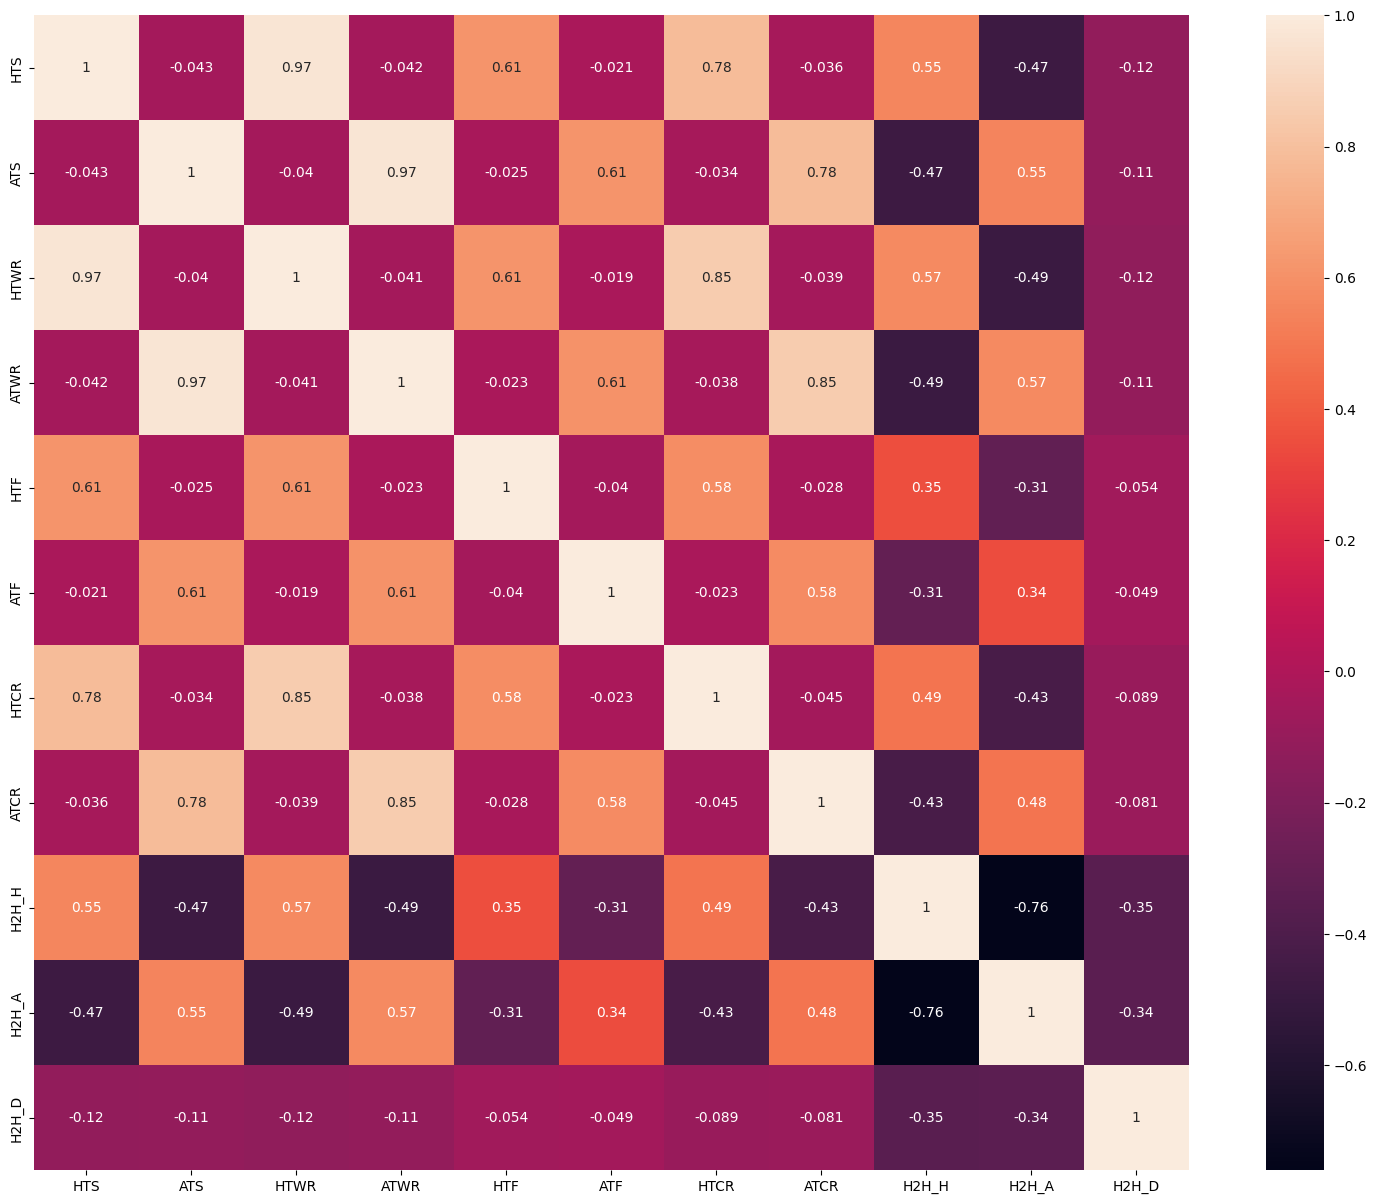

In [29]:
# Correlation of Numerical Features
fig, ax = plt.subplots(figsize = (20, 15))
sns.heatmap(df_input.corr(), annot = True, square = True);

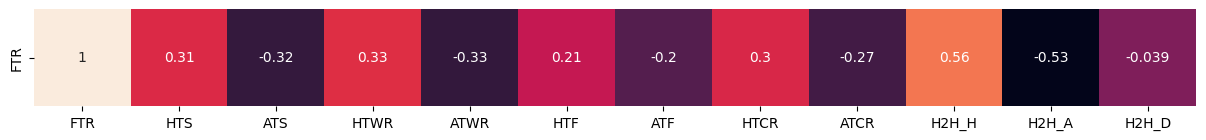

In [30]:
df_input['FTR'].replace({'H': 1, 'D': 0, 'A': -1}, inplace = True)

fig, ax = plt.subplots(figsize = (15, 2))
sns.heatmap(df_input.corr()[['FTR']].T, annot = True, square = True, cbar = False);

In [31]:
# There is strong correlation between various features. However, there is no problem in terms of dimensionality,
# due to the small number of features. Additionally, this combination of features has led to the highest accuracy,
# so no additional features will be removed. Substantial effort has been made to combine highly correlated features,
# but this was either not feasible, or resulted in considerable drop in accuracy.

# The constructed features present a high correlation with the target variable (FTR). H2H_D is the only feature
# that is not highly correlated with FTR. However, it is possible that a non-linear relationship exists between
# the two variables, as the inclusion of H2H_D increased the accuracy of models in predicting draws.

## 5. Model Training & Validation

In [32]:
X, y = df_input.drop(['HOME', 'AWAY', 'FTR'], axis = 1), df_input['FTR'].copy()

In [33]:
# Balance Dataset

# Random Under Sampling
# rus = RandomUnderSampler()
# X, y = rus.fit_resample(X, y)

# Random Over Sampling
# ros = RandomOverSampler()
# X, y = ros.fit_resample(X, y)

# sns.displot(y);

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)

In [35]:
# Standard Scaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Min-Max Scaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
lr = LogisticRegression()

lr.fit(X_train, y_train)
y_lr = lr.predict(X_test)

# print(accuracy_score(y_test, y_lr))
print(classification_report(y_test, y_lr, digits = 4))

              precision    recall  f1-score   support

          -1     0.6056    0.6370    0.6209       135
           0     0.6136    0.4252    0.5023       127
           1     0.6486    0.7579    0.6990       190

    accuracy                         0.6283       452
   macro avg     0.6226    0.6067    0.6074       452
weighted avg     0.6260    0.6283    0.6204       452



In [37]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
y_knn = knn.predict(X_test)

# print(accuracy_score(y_test, y_knn))
print(classification_report(y_test, y_knn, digits = 4))

              precision    recall  f1-score   support

          -1     0.4565    0.6222    0.5266       135
           0     0.4545    0.2756    0.3431       127
           1     0.6283    0.6316    0.6299       190

    accuracy                         0.5288       452
   macro avg     0.5131    0.5098    0.4999       452
weighted avg     0.5282    0.5288    0.5185       452



In [38]:
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)
y_dt = dt.predict(X_test)

# print(accuracy_score(y_test, y_dt))
print(classification_report(y_test, y_dt, digits = 4))

              precision    recall  f1-score   support

          -1     0.4337    0.5333    0.4784       135
           0     0.3299    0.2520    0.2857       127
           1     0.5714    0.5684    0.5699       190

    accuracy                         0.4690       452
   macro avg     0.4450    0.4512    0.4447       452
weighted avg     0.4624    0.4690    0.4627       452



In [39]:
svm = SVC()

svm.fit(X_train, y_train)
y_svm = svm.predict(X_test)

# print(accuracy_score(y_test, y_svm))
print(classification_report(y_test, y_svm, digits = 4))

              precision    recall  f1-score   support

          -1     0.5685    0.6148    0.5907       135
           0     0.5667    0.2677    0.3636       127
           1     0.6138    0.7947    0.6927       190

    accuracy                         0.5929       452
   macro avg     0.5830    0.5591    0.5490       452
weighted avg     0.5870    0.5929    0.5698       452



In [40]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)
y_gnb = gnb.predict(X_test)

# print(accuracy_score(y_test, y_gnb))
print(classification_report(y_test, y_gnb, digits = 4))

              precision    recall  f1-score   support

          -1     0.5723    0.6741    0.6190       135
           0     0.5833    0.3858    0.4645       127
           1     0.6699    0.7368    0.7018       190

    accuracy                         0.6195       452
   macro avg     0.6085    0.5989    0.5951       452
weighted avg     0.6164    0.6195    0.6104       452



In [41]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)

# print(accuracy_score(y_test, y_rf))
print(classification_report(y_test, y_rf, digits = 4))

              precision    recall  f1-score   support

          -1     0.4514    0.4815    0.4659       135
           0     0.3516    0.2520    0.2936       127
           1     0.5530    0.6316    0.5897       190

    accuracy                         0.4801       452
   macro avg     0.4520    0.4550    0.4497       452
weighted avg     0.4661    0.4801    0.4695       452



In [42]:
# Initially, the method train_test_split() is used, which randomly splits the dataset in a training and a
# testing set. Thus, the models are trained once and their accuracy is only evaluated on the single testing
# set. Due to the number of available samples, as well as the imbalance in the distribution of classes in
# the target variable (FTR), this method can produce innacurate results on the performance of the models.

# A suitable approach is the use of cross_val_score(), which internally performs a Stratified K-Fold Split
# and evaluates the models on k different subsets of the dataset, thus providing more concrete results. The
# complete dataset is used (X, y), as this is a method to determine the robustness and stability of models.

In [43]:
X = scaler.fit_transform(X)

lr = LogisticRegression()
cv_lr = cross_val_score(lr, X, y).mean()

knn = KNeighborsClassifier()
cv_knn = cross_val_score(knn, X, y).mean()

dt = DecisionTreeClassifier()
cv_dt = cross_val_score(dt, X, y).mean()

svm = SVC()
cv_svm = cross_val_score(svm, X, y).mean()

gnb = GaussianNB()
cv_gnb = cross_val_score(gnb, X, y).mean()

rf = RandomForestClassifier()
cv_rf = cross_val_score(rf, X, y).mean()

In [44]:
# Through cross-validation, the best-performing models are: SVM, Logistic Regression and Gaussian Naive Bayes.
# Now, a Grid Search is performed to determine the optimal hyper-parameters for the models.

In [45]:
# Grid Search CV (LR)

lr = LogisticRegression()

grid = {'C': [0.5, 1.0, 1.5, 2.0, 2.5], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}

clf = GridSearchCV(lr, grid)
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

# gs_lr = clf.predict(X_test)
# print(accuracy_score(y_test, gs_lr))

{'C': 1.5, 'solver': 'newton-cg'}
0.6426592797783934


In [46]:
# Grid Search CV (KNN)

knn = KNeighborsClassifier()

grid = {'n_neighbors': [10, 50, 100, 200], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

clf = GridSearchCV(knn, grid)
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

# gs_knn = clf.predict(X_test)
# print(accuracy_score(y_test, gs_knn))

{'algorithm': 'auto', 'n_neighbors': 50}
0.6182825484764543


In [47]:
# Grid Search CV (DT)

dt = DecisionTreeClassifier()

grid = {'max_depth': [2, 4, 6, 8]}

clf = GridSearchCV(dt, grid)
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

# gs_dt = clf.predict(X_test)
# print(accuracy_score(y_test, gs_dt))

{'max_depth': 4}
0.6288088642659281


In [48]:
# Grid Search CV (SVM)

svm = SVC()

grid = {'C': [0.1, 1.0], 'kernel': ['linear', 'poly', 'rbf']}

clf = GridSearchCV(svm, grid)
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

# gs_svm = clf.predict(X_test)
# print(accuracy_score(y_test, gs_svm))

{'C': 1.0, 'kernel': 'linear'}
0.6426592797783932


In [49]:
# Grid Search CV (RF)

rf = RandomForestClassifier()

grid = {'n_estimators': [25, 50, 100], 'max_depth': [2, 4, 8, 16]}

clf = GridSearchCV(rf, grid)
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

# gs_rf = clf.predict(X_test)
# print(accuracy_score(y_test, gs_rf))

{'max_depth': 4, 'n_estimators': 100}
0.6332409972299169


## 6. Results

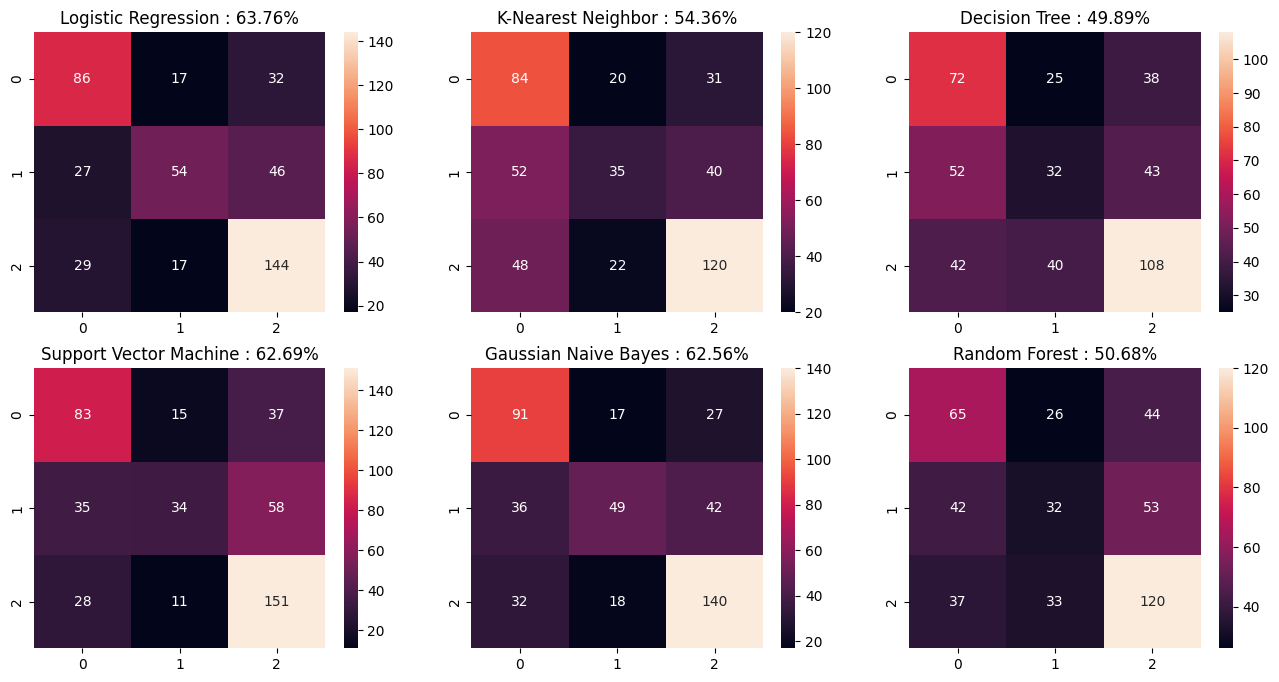

In [50]:
# Baseline Models
outputs = [y_lr, y_knn, y_dt, y_svm, y_gnb, y_rf]
cross_val = [cv_lr, cv_knn, cv_dt, cv_svm, cv_gnb, cv_rf]

fig, ((ax_lr, ax_knn, ax_dt), (ax_svm, ax_gnb, ax_rf)) = plt.subplots(2, 3, figsize = (16, 8))

results = pd.DataFrame()

results['Model'] = ['Logistic Regression', 'K-Nearest Neighbor', 'Decision Tree',
                    'Support Vector Machine', 'Gaussian Naive Bayes', 'Random Forest']

results['Accuracy'] = [100 * i for i in cross_val]

results['Axis'] = [ax_lr, ax_knn, ax_dt, ax_svm, ax_gnb, ax_rf]

results['Output'] = [y_lr, y_knn, y_dt, y_svm, y_gnb, y_rf]

results = results.round(decimals = 2)

for index, row in results.iterrows():
    title = '{} : {}%'.format(row['Model'], row['Accuracy'])

    row['Axis'].set_title(title)

    cm = confusion_matrix(y_test, row['Output'])
    sns.heatmap(cm, annot = True, fmt = 'd', ax = row['Axis']);

## 7. Final Predictions on Test Set

In [51]:
# Final Model with Optimized Hyper-Parameters (SVM)
final = SVC(C = 1.0, kernel = 'linear')
final.fit(X, y);

In [52]:
# Prediction
path = os.path.join(cwd, 'Data_Files', 'epl-test.csv')

df_test = pd.read_csv(path)
df_test['FTR'] = np.nan

df_final = create_DF(df_test, df_teams)
df_final = df_final.drop(['HOME', 'AWAY', 'FTR'], axis = 1)

df_final = scaler.transform(df_final)

predictions = final.predict(df_final)

df_test['FTR'] = predictions
df_test['FTR'] = df_test['FTR'].replace({1: 'H', 0: 'D', -1: 'A'})

display(df_test)

path = os.path.join(cwd, 'Data_Files', 'epl-predictions.csv')
df_test.to_csv(path, index = False)

,Date,HomeTeam,AwayTeam,FTR
0,15 Jan 22,Aston Villa,Man United,A
1,15 Jan 22,West Ham,Leeds,H
2,15 Jan 22,Norwich,Everton,H
3,15 Jan 22,Brighton,Crystal Palace,D
4,15 Jan 22,Wolves,Southampton,H
5,15 Jan 22,Liverpool,Brentford,D
6,15 Jan 22,Tottenham,Arsenal,H
7,15 Jan 22,Man City,Chelsea,H
8,15 Jan 22,Newcastle,Watford,D
9,15 Jan 22,Burnley,Leicester,A
